In [1]:
import os
os.chdir("../../../")
import numpy as np
import pandas as pd
from itertools import combinations, product
from src.tourism.ts_utils import check_and_modify_date
from src.tourism.mtsmodel import *
from src.tourism.utsmodel import *

In [2]:
mts = MultiTSData(country="samoa",
                  y_var="total",
                  exog_var=["covid", "stringency_index"],
                  transform_method="scaledlogit",
                  training_ratio=0.9)

mts.read_and_merge()

In [2]:
e = RatioPipe("samoa",
          y_var="total",
          exog_var=["covid", "stringency_index"],
          transform_method="scaledlogit",
          training_ratio=0.9)
e.read_and_merge()
e.transform()

In [5]:
e.get_prediction()

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.522368,13755.0,26332.0,0.617924,0.071371,0.478040,0.757809,0.316003,0.919846,16271.183098
1,2019-02-01,0.522171,9044.0,17320.0,0.557770,0.053334,0.453238,0.662302,0.270514,0.845025,9660.570200
2,2019-03-01,0.535575,11163.0,20843.0,0.502438,0.060181,0.384486,0.620390,0.210032,0.794844,10472.317235
3,2019-04-01,0.692899,14413.0,20801.0,0.566465,0.088135,0.393723,0.739207,0.247986,0.884943,11783.031807
4,2019-05-01,0.650818,13565.0,20843.0,0.575340,0.083838,0.411020,0.739660,0.261350,0.889330,11991.819340
5,2019-06-01,0.762766,16192.0,21228.0,0.648935,0.060041,0.531258,0.766613,0.356640,0.941231,13775.599033
6,2019-07-01,0.842978,24647.0,29238.0,0.744593,0.049324,0.647919,0.841267,0.460103,1.029083,21770.402070
7,2019-08-01,0.764079,17489.0,22889.0,0.746196,0.049586,0.649009,0.843384,0.461531,1.030861,17079.680980
8,2019-09-01,0.722718,16212.0,22432.0,0.749435,0.050181,0.651082,0.847788,0.464370,1.034500,16811.320355
9,2019-10-01,0.667248,14544.0,21797.0,0.623273,0.035021,0.554633,0.691913,0.347048,0.899498,13585.475557


In [4]:
e.fit(formula="ratio~covid * stringency_index+C(quarter)+samoa_flights")
e.res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     63.35
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           1.16e-18
Time:                        23:52:33   Log-Likelihood:                 30.162
No. Observations:                  45   AIC:                            -44.32
Df Residuals:                      37   BIC:                            -29.87
Df Model:                           7                                         
Covariance Type:                  HAC                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2438      0.208      1.170      0.242      -0.165       0.652
C(quarter)[T.2]            0.0587      0.072      0.811      0.417      -0.083       0.201
C(quarter)[T.3]            0.1307      0.066      1.984      0.047       0.002       0.260
C(quarter)[T.4]            0.0448      0.043      1.045      0.296      -0.039       0.129
covid                     -0.1234      0.252     -0.490      0.624      -0.616       0.370
stringency_index          -0.0066      0.002     -2.770      0.006      -0.011      -0.002
covid:stringency_index -5.409e-05      0.005     -0.012      0.991      -0.009       0.009
samoa_flights              0.1392      0.093      1.498      0.134      -0.043       0.321
==============================================================================
Omnibus:                       16.501   Durbin-Watson:                   0.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.768
Skew:                           0.880   Prob(JB):                     2.82e-08
Kurtosis:                       6.930   Cond. No.                         524.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and with small sample correction
"""

In [2]:
avi_path = os.getcwd() + "/data/tourism/rank_psg_Full Data_data.csv"

df = pd.read_csv(avi_path)
df.columns = [col.lower().replace(" ", "_") for col in df.columns]
df["date"] = pd.to_datetime(df["date"])
df_sel = df[["date", "type","destination_country","passengers_number"]]
df_sel["type"] = df_sel["type"].apply(lambda x: "International" if x != "Domestic" else "Domestic")

In [3]:
df_new = df_sel.pivot_table(values="passengers_number",
                            index=["destination_country", "date"],
                            columns="type").reset_index()

In [4]:
countries_unique = df["destination_country"].unique().tolist()
date_min, date_max = df.date.min(), df.date.max()
dates_unique = pd.date_range(date_min, date_max, freq="D").tolist()

date_df = pd.DataFrame([*product(countries_unique, dates_unique)], columns=["country", "date"])

In [5]:
df_clean = date_df.merge(df_new,
                         how="left",
                         left_on=["country", "date"],
                         right_on=["destination_country", "date"]).fillna(0)
df_clean = df_clean.drop("destination_country", axis=1)
df_clean.columns = [col.lower() for col in df_clean.columns]
df_clean["seats_arrivals_total"] = df_clean[["domestic", "international"]].sum(axis=1)
df_clean = df_clean.rename({"domestic": "seats_arrivals_domestic",
                            "international": "seats_arrivals_intl"}, axis=1)
df_clean

,country,date,seats_arrivals_domestic,seats_arrivals_intl,seats_arrivals_total
0,Samoa,2020-01-01,0.0,817.0,817.0
1,Samoa,2020-01-02,19.0,538.0,557.0
2,Samoa,2020-01-03,0.0,446.0,446.0
3,Samoa,2020-01-04,0.0,1263.0,1263.0
4,Samoa,2020-01-05,0.0,560.0,560.0
...,...,...,...,...,...
7000,Vanuatu,2023-10-28,560.0,752.0,1312.0
7001,Vanuatu,2023-10-29,350.0,484.0,834.0
7002,Vanuatu,2023-10-30,280.0,558.0,838.0
7003,Vanuatu,2023-10-31,0.0,554.0,554.0


In [6]:
avi = pd.read_excel("/Users/czhang/Desktop/pacific-observatory/data/tourism/aviation_seats_flights_pic.xlsx")
avi.columns = [col.lower().replace(" ", "") for col in avi.columns]
avi["date"] = pd.to_datetime(avi["date"])
avi = avi[avi.aircraft_type == "passenger"].reset_index(drop=True)
avi_select = avi[["date", "country", "seats_arrivals_domestic", "seats_arrivals_intl", "seats_arrivals_total"]]

In [7]:
avi_min, avi_max = avi.date.min(), avi.date.max()
avidu = pd.date_range(avi_min, avi_max, freq="D").tolist()
avi_clean = pd.DataFrame([*product(countries_unique, avidu)], columns=["country", "date"])
avi_df = avi_clean.merge(avi_select, how="left").fillna(0)
avi_df = avi_df[avi_df.date < "2022-10-01"].reset_index(drop=True)

In [8]:
df_clean = df_clean[(df_clean.date >= "2022-10-01") & (df_clean.date < "2023-11-01")].reset_index(drop=True)

In [12]:
df_final = (pd.concat([avi_df, df_clean])
            .drop_duplicates()
            .sort_values(by=["country", "date"],ascending=True)
            .reset_index(drop=True))
df_final.to_csv(os.getcwd() + "/data/tourism/aviation_data_201901-202310.csv", encoding="utf-8")

In [ ]:
ratio_df = pd.read_csv(
    "/Users/czhang/Desktop/pacific-observatory/data/tourism/samoa/intermediate/samoa_merged.csv"
).drop("Unnamed: 0", axis=1)

In [7]:
ratio_df.columns = [col.lower() for col in ratio_df.columns]
import statsmodels.formula.api as smf

In [9]:
ratio_df["date"] = [
    pd.to_datetime(str(y) + "-" + str(m))
    for y, m in zip(ratio_df.year, ratio_df.month)
]

In [10]:
st_df = pd.read_csv(
    "/Users/czhang/Desktop/pacific-observatory/data/tourism/oceania_covid_stringency.csv"
).drop("Unnamed: 0", axis=1)
st_df["date"] = pd.to_datetime(st_df["date"])
ratio_df = ratio_df.merge(st_df, how="left", on="date").fillna(0)

In [11]:
ratios = []
for x1, x2 in zip(ratio_df["total"], ratio_df["seats_arrivals_intl"]):
    if x2 == 0:
        ratio = 0
    else:
        ratio = x1/x2
    ratios.append(ratio)

# Adjust the ratio ex post
for idx, ratio in enumerate(ratios):
    if ratio >= 1:
        print(f"Abnormal value produced with a value of {ratio}.")
        ratios[idx] = ((ratios[idx-1] + ratios[idx+1]))/2
ratio_df["ratio"] = ratios

ratio_df["log_ratio"] = np.where(ratio_df["ratio"] == 0, 0,
                                  np.log(ratio_df["ratio"] * 100))

In [12]:
ratio_df["quarter"] = ratio_df["date"].dt.quarter
ratio_df["covid"] = ratio_df["date"] >= pd.to_datetime("2020-03-11")

In [13]:
trends = pd.read_csv("/Users/czhang/Desktop/pacific-observatory/data/tourism/trends/trends_samoa.csv").drop("Unnamed: 0", axis=1)
trends["date"] = pd.to_datetime(trends["date"])
ratio_df = ratio_df.merge(trends[["date", "samoa travel"]], how="left").rename({"samoa travel": "samoa_travel"}, axis=1)

In [15]:
new = trends[["date", "samoa travel"]].merge(st_df, how="left")
new["quarter"] = new["date"].dt.quarter
new = new[new.date >= "2022-10-01"].reset_index(drop=True).rename({"samoa travel": "samoa_travel"}, axis=1).fillna(0)
new["covid"] = new["date"] <= pd.to_datetime("2023-05-11")
new

,date,samoa_travel,stringency_index,quarter,covid
0,2022-10-01,0.673550,15.635685,4,True
1,2022-11-01,0.759518,14.692042,4,True
2,2022-12-01,0.647522,13.913911,4,True
3,2023-01-01,0.855296,0.000000,1,True
4,2023-02-01,0.741480,0.000000,1,True
5,2023-03-01,0.758449,0.000000,1,True
6,2023-04-01,0.689868,0.000000,2,True
7,2023-05-01,0.906480,0.000000,2,True
8,2023-06-01,0.855324,0.000000,2,False
9,2023-07-01,0.665429,0.000000,3,False


In [16]:
mod = smf.ols("ratio~covid * stringency_index+C(quarter)+ samoa_travel", data=ratio_df)
res = mod.fit()

In [42]:
pred_df = res.get_prediction(new).summary_frame()
pred_df

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.236292,0.095188,0.043423,0.429160,-0.104279,0.576862
1,0.265743,0.095718,0.071800,0.459686,-0.075437,0.606924
2,0.241736,0.100290,0.038530,0.444942,-0.104793,0.588266
3,0.337226,0.134228,0.065254,0.609198,-0.053618,0.728070
4,0.307172,0.136938,0.029710,0.584634,-0.087512,0.701856
5,0.311653,0.136380,0.035321,0.587985,-0.082237,0.705543
6,0.350128,0.140569,0.065307,0.634949,-0.049763,0.750019
7,0.407326,0.133026,0.137790,0.676863,0.018173,0.796480
8,0.627452,0.054568,0.516888,0.738017,0.325766,0.929139
9,0.658495,0.072426,0.511746,0.805244,0.341753,0.975237


In [68]:
new["ratio_hat"] = pred_df["mean"]
new["ratio_upper"] = pred_df["mean_ci_upper"]
new["ratio_lower"] = pred_df["mean_ci_lower"]
new = new.merge(pass_df, how="left").fillna(0)

new["predict"] = new["predict_upper"] = new["predict_lower"] = 0
for idx, val in enumerate(new["passengers_number"]):
    new["predict"][idx] = new["ratio_hat"][idx] * val
    new["predict_upper"][idx]  = new["ratio_upper"][idx] * val
    new["predict_lower"][idx]  = new["ratio_lower"][idx] * val
    
new = new.iloc[:-2, :]

In [46]:
real = [
    6917, 8085, 16009, 11868, 7273, 9643, 13271, 15321, 17122, 16145, 15829,
    14351, 12729
]

real_df = pd.DataFrame({
    "date":
    pd.date_range(start="2022-10-01", periods=len(real), freq="MS"),
    "actual_visitor":
    real
})

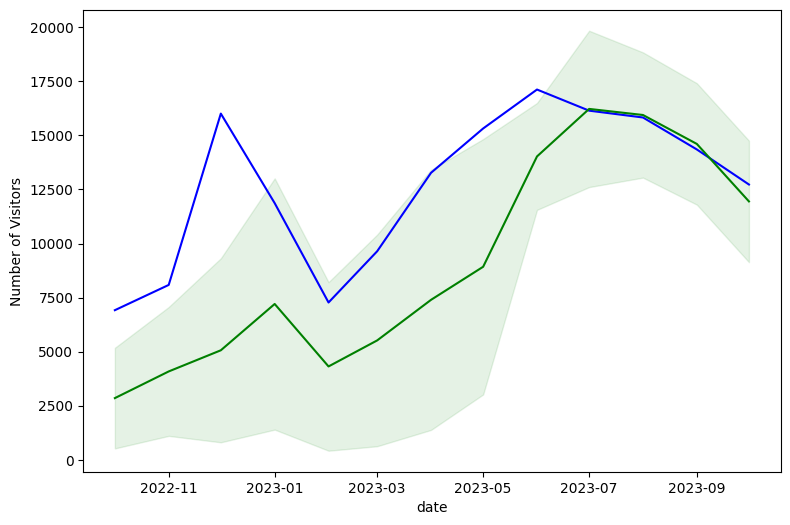

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9, 6))
sns.lineplot(data=real_df, x="date", y="actual_visitor", ax=ax, color="blue")
sns.lineplot(data=new, x="date", y="predict", ax=ax, color="green")
plt.fill_between(x=new.date, y1=new.predict_lower, y2=new.predict_upper, alpha=0.1, color="green")
ax.set_ylabel("Number of Visitors")
plt.show()